In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import scipy
import json
from tqdm import tqdm 
import math
from pathlib import Path
import seaborn as sns
import os
import random
import os.path
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
sns.set_theme()

In [2]:
colors = ['#5E81B5','#8FB032','#EB6235','#8778B3','#E19C24']
dataset = 'ml'
# colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
markers = ['o','s','^']

# Load functions

In [28]:
def data_stats(data):
    users = len(data.userid.unique())
    items = len(data.itemid.unique())
    ratings = len(data)
    print('#users: ' + str(users))
    print('#items: ' + str(items))
    print('#ratings: ' + str(ratings))
    print('density: ' + str(ratings / (users * items)))
def popularity_computation(data):
    n_users = len(data['userid'].unique())
    df = data.groupby('itemid').size().reset_index(name='counts')
    df['pop'] = df['counts'] / n_users
    return df
def select_most_popular_items(data, ratio):
    items = list(data['itemid'].unique())
    selected_items_size = int(len(items) * ratio)
    return list(data.groupby('itemid').size().reset_index(name='counts').sort_values('counts',ascending=False).head(selected_items_size)['itemid'].values)
def create_HT(train, head_ratio):
    train_df = train.groupby('itemid').size().reset_index(name='counts')
    train_df['pop'] = train_df['counts'] / len(train)
    train_df = train_df.sort_values('pop', ascending=False)
    head, tail = [], []
    sum_pop = 0.0
    for index,row in train_df.iterrows():
        sum_pop += row['pop']
        if sum_pop < head_ratio:
            head.append(int(row['itemid']))
        else:
            tail.append(int(row['itemid']))
    return head, tail
def add_items_exposure(recs):
    recs = add_item_rank_recs(recs)
    recs['exp'] = recs.apply(lambda row: compute_exposure(row['rank']+1), axis=1)
    return recs.groupby(['itemid'])['exp'].sum().reset_index()
def add_item_rank_recs(recs):
    df = pd.DataFrame(columns=['userid','itemid','rate','rank'])
    users = list(recs.userid.unique())
    for user in users:
        user_rec = recs[recs.userid==user]
        user_rec_sorted = user_rec.sort_values('rate', ascending=False)
        user_rec_sorted['rank'] = list(range(len(user_rec_sorted)))
        df = pd.concat([df, user_rec_sorted], ignore_index=True)#df.append(user_rec_sorted)
    return df
def compute_exposure(rank):
    return 1 / (math.log(1+rank,2))
def compute_precision(rec_data, test_data):
    users = list(test_data['userid'].unique())
    precision = 0.0
    for user in users:
        recs = set(list(rec_data[rec_data['userid'] == user]['itemid']))
        ground = set(list(test_data[test_data['userid'] == user]['itemid']))
        precision += len(recs & ground) / len(recs)
    return precision / len(users)
def compute_recall(rec_data, test_data):
    users = list(test_data['userid'].unique())
    recall = 0.0
    for user in users:
        recs = set(list(rec_data[rec_data['userid'] == user]['itemid']))
        ground = set(list(test_data[test_data['userid'] == user]['itemid']))
        recall += len(recs & ground) / len(ground)
    return recall / len(users)
def compute_ndcg(recommendedList, groundTruthList):
    nDCG = 0.0
    Users = list(recommendedList['userid'].unique())
    nonZeroContext = 0

    for user in Users:
        testSetByContext = set(groundTruthList[groundTruthList['userid']==user]['itemid'])
        if len(testSetByContext) > 0:
            groundTruthTestSetByContext = groundTruthList[groundTruthList['userid']==user]
            recommendListByContext = recommendedList[recommendedList['userid']==user]
            hasdcgsValue = False

            groundTruthTestSet = groundTruthTestSetByContext

            dcg = 0.0
            topK = len(recommendListByContext)
            recommendListByContext = recommendListByContext.sort_values('rate',ascending=False)
            indexOfKey = 0
            for index,row in recommendListByContext.iterrows():
                if row['itemid'] in testSetByContext:
                    rankvalue = groundTruthTestSet[groundTruthTestSet['itemid']==row['itemid']]['rate'].values[0]
                    hasdcgsValue = True
                    dcg += rankvalue / math.log((indexOfKey + 2), 2)
                indexOfKey +=1

                if hasdcgsValue and dcg!=0.0:
                    idcg = 0.0

                    idcgsValue = list(groundTruthTestSet['rate'])
                    idcgsValue = sorted(idcgsValue, reverse=True)

                    if topK < len(idcgsValue):
                        validIdxNum = topK
                    else:
                        validIdxNum = len(idcgsValue)

                    for i in range(validIdxNum):
                        idcg += idcgsValue[i] / math.log((i + 2), 2)

                    if idcg == 0.0:
                        nonZeroContext += 1
                    else:
                        nDCG += dcg / idcg
                        nonZeroContext += 1
                else:
                    nonZeroContext += 1
    if nonZeroContext > 0:
        return nDCG / nonZeroContext
    return 0.0
def aggregate_diversity(rec_data, items, threshold):
    df = rec_data.groupby(['itemid']).size().reset_index(name='counts')
    return len(df[df['counts'] >= threshold]) / len(items)
def gini(array):
    list_of_values = array
    item_n = len(list_of_values)
    total_users_seen_item = sum(list_of_values)
    np_item_c = np.array(list_of_values)
    p = []
    for k in range(len(list_of_values)):
        p.append(list_of_values[k] / float(total_users_seen_item))
    ent = scipy.stats.entropy(p)
    p = sorted(p)
    c = 1.0 / (item_n - 1)
    sum_1 = 0
    for k in range(item_n):
        a = 2.0 * k - item_n - 1
        if p[k] > 1.0 or p[k] < 0:
            raise Exception('p is not bounded in [0,1].')
        sum_1 += (a * p[k])
    return c * sum_1
def aggregate_diversity_longtail(rec_data, items, threshold, tail_items):
    df = rec_data.groupby(['itemid']).size().reset_index(name='counts')
    df = df[df['itemid'].isin(tail_items)]
    return len(df[df['counts'] >= threshold]) / len(items)

In [20]:
def metrics_computation_for_ratios(dataset, alg, input_type, ratios, train, tail):
    items = list(train['itemid'].unique())
    df_pop = popularity_computation(train)
    precision, recall, ndcg, agg_div1, agg_div5, agg_div10, exposure = [], [], [], [], [], [], []
    agg_div1_lt, agg_div5_lt, agg_div10_lt = [], [], []

    for ratio in tqdm(ratios):
        if ratio == 0:
            rec_data = pd.read_csv('datasets/'+dataset + '/' + input_type + '_' + alg, names=['userid', 'itemid', 'rate'], sep=',')
        else:
            rec_data = pd.read_csv('datasets/'+dataset + '/' + input_type + '_' + alg + '_' + str(ratio), names=['userid', 'itemid', 'rate'], sep=',')

        rec_data_pos_exp = add_items_exposure(rec_data)
        rec_data_pos_exp_arr = np.concatenate((rec_data_pos_exp['exp'], (len(items) - len(rec_data_pos_exp)) * [0]), axis=0)
        
        precision.append(compute_precision(rec_data, test))
        recall.append(compute_recall(rec_data, test))
        ndcg.append(compute_ndcg(rec_data, test))
        agg_div1.append(aggregate_diversity(rec_data, items, 1))
        agg_div5.append(aggregate_diversity(rec_data, items, 5))
        agg_div10.append(aggregate_diversity(rec_data, items, 10))
        exposure.append(gini(rec_data_pos_exp_arr))
        agg_div1_lt.append(aggregate_diversity_longtail(rec_data, items, 1, tail))
        agg_div5_lt.append(aggregate_diversity_longtail(rec_data, items, 5, tail))
        agg_div10_lt.append(aggregate_diversity_longtail(rec_data, items, 10, tail))

    equality = 1-np.array(exposure)

    return precision, recall, ndcg, agg_div1, agg_div5, agg_div10, agg_div1_lt, agg_div5_lt, agg_div10_lt, equality

# Overall

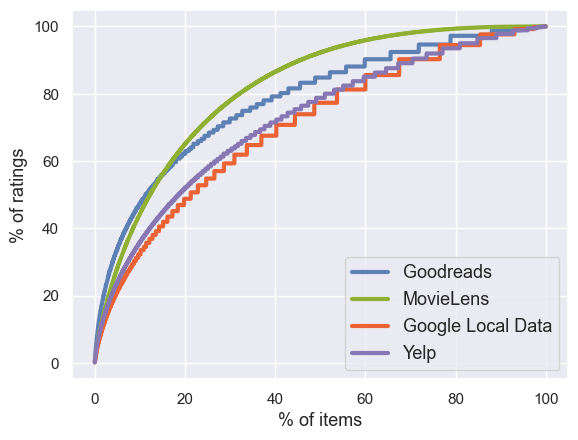

In [3]:
datasets = ['goodreads', 'ml', 'glr', 'yelp']
datasets_label = ['Goodreads', 'MovieLens', 'Google Local Data', 'Yelp']

for k in range(len(datasets)):
    train = pd.read_csv('datasets/'+datasets[k]+'/train.txt',names=['userid','itemid','rate'], sep='\t')
    df_pop = train.groupby('itemid').size().reset_index(name='counts').sort_values('counts',ascending=False)
    df_pop['pop'] = df_pop['counts'] / len(train)
    per_item, per_pop = [], []
    i = 1
    for index,row in df_pop.iterrows():
        per_item.append(i * 100/ len(df_pop))
        above_rows = df_pop[df_pop['pop'] >= row['pop']]
        per_pop.append(sum(above_rows['pop']) * 100 / sum(df_pop['pop']))
        i += 1
    df_pop['x'] = per_item
    df_pop['y'] = per_pop
    ax = sns.lineplot(data=df_pop, x="x", y="y",linewidth=3, color=colors[k], label=datasets_label[k])

ax.set_xlabel("% of items",fontsize=13)
ax.set_ylabel("% of ratings",fontsize=13)
ax.legend(fontsize=13)

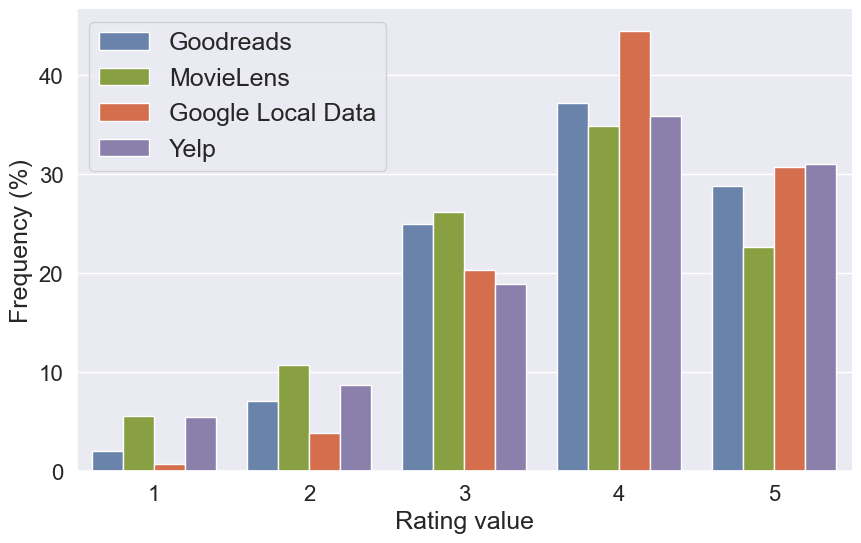

In [4]:
datasets = ['goodreads', 'ml', 'glr', 'yelp']
datasets_label = ['Goodreads', 'MovieLens', 'Google Local Data', 'Yelp']

df_rate = pd.DataFrame({"rate": [1, 2, 3, 4, 5]})
for k in range(len(datasets)):
    train = pd.read_csv('datasets/'+datasets[k]+'/train.txt',names=['userid','itemid','rate'], sep='\t')
    df_rate1 = train.groupby('rate').size().reset_index(name='counts').sort_values('rate')
    df_rate[datasets_label[k]] = df_rate1['counts'] * 100 / len(train)

df_rate_data = df_rate.melt(id_vars='rate', var_name="Dataset").rename(columns=str.title)
palette = {
    'Goodreads': colors[0],
    'MovieLens': colors[1],
    'Google Local Data': colors[2],
    'Yelp': colors[3]
}

fig, ax1 = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x='Rate', y='Value', hue='Dataset', data=df_rate_data, palette=palette, ax=ax1)
ax.set_xlabel("Rating value",fontsize=18)
ax.set_ylabel("Frequency (%)",fontsize=18)
ax.set_yticklabels(ax.get_yticks().astype(int), size = 16)
ticks = np.array(ax.get_xticks())     
new_labels = (ticks + 1).astype(int)
ax.set_xticklabels(new_labels.astype(str), fontsize=16)
ax.legend(fontsize=18)
sns.despine(fig)

# Data analysis

In [7]:
train = pd.read_csv('datasets/'+dataset+'/train.txt',names=['userid','itemid','rate'], sep='\t')
data_stats(train)

#users: 6040
#items: 3679
#ratings: 797758
density: 0.03590082605948564


(1.0, 5.0)

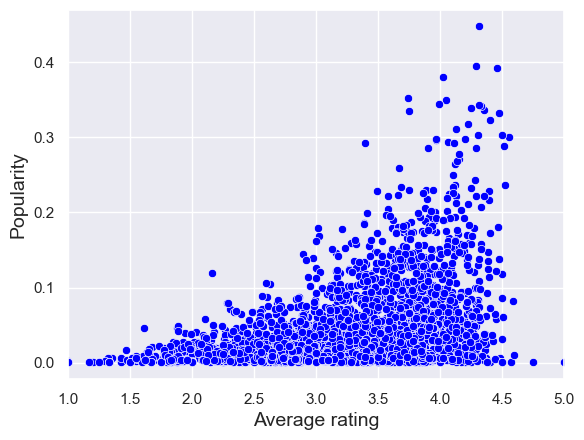

In [10]:
df_pop = popularity_computation(train)
df_avg_rating = train[['itemid','rate']].groupby('itemid').mean()
df = pd.merge(df_pop, df_avg_rating, how='left', on=['itemid'])
ax = sns.scatterplot(data=df, x="rate", y="pop", color='blue')
ax.set_xlabel("Average rating",fontsize=14)
ax.set_ylabel("Popularity",fontsize=14)
ax.set_xlim(1, 5)

### Change the rating of popular items

In [13]:
ratios = [0.01,0.03,0.05,0.07,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
train = pd.read_csv('datasets/'+dataset+'/train.txt',names=['userid','itemid','rate'],sep='\t')
for ratio in ratios:
    selected_items = select_most_popular_items(train, ratio)
    f = open('datasets/'+dataset+'/train_'+str(ratio)+'.txt','w')
    for index,row in train.iterrows():
        if row['itemid'] in selected_items and row['rate'] > 3:
            f.write(str(row['userid']) + '\t' + str(row['itemid']) + '\t' + str(1) + '\n')
        else:
            f.write(str(row['userid']) + '\t' + str(row['itemid']) + '\t' + str(row['rate']) + '\n')
f.close()

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


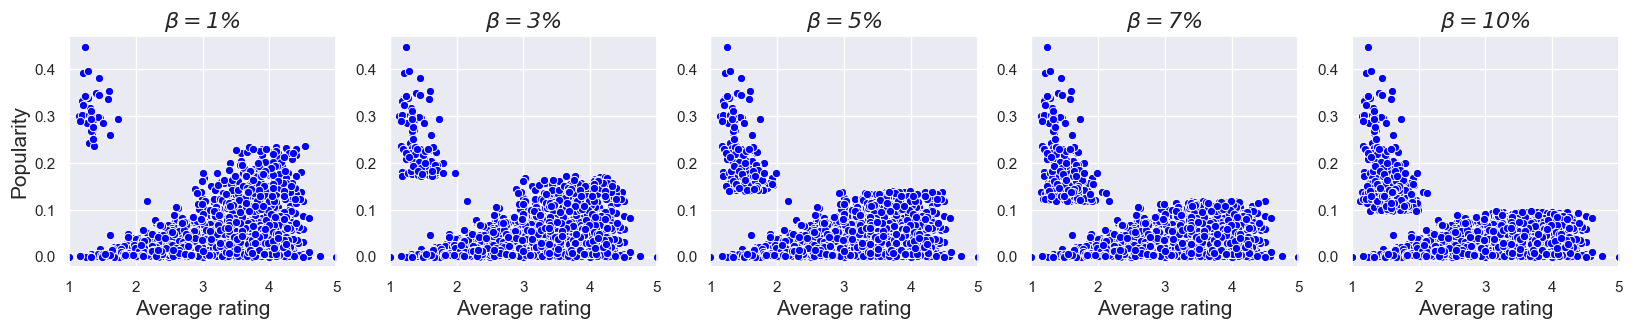

In [14]:
ratios = [0.01, 0.03, 0.05, 0.07, 0.1]

fig = plt.figure(figsize=(20,3))
for ratio in ratios:
    train = pd.read_csv('datasets/'+dataset+'/train_'+str(ratio)+'.txt', names=['userid','itemid','rate'], sep='\t')
    
    df_pop = popularity_computation(train)
    df_avg_rating = train[['itemid','rate']].groupby('itemid').mean()
    df = pd.merge(df_pop, df_avg_rating, how='left', on=['itemid'])
    
    plt.subplot(1, len(ratios), ratios.index(ratio)+1)
    ax = sns.scatterplot(data=df, x="rate", y="pop", color='blue', linewidth=0.7)
    ax.set_xlabel("Average rating",fontsize=15)
    if ratios.index(ratio) == 0:
        ax.set_ylabel("Popularity",fontsize=15)
    else:
        ax.set_ylabel("",fontsize=12)
    ax.set_xlim(1, 5)
    ax.set_title(r'$\beta=$'+str(int(ratio*100))+'%',fontsize=16)

# Simulation analysis

In [30]:
alg, input_type = 'biasedmf', 'rating'
ratios = [0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
test = pd.read_csv('datasets/'+dataset+'/test.txt',names=['userid','itemid','rate'],sep='\t')
train = pd.read_csv('datasets/'+dataset+'/train.txt',names=['userid','itemid','rate'],sep='\t')
items = list(train['itemid'].unique())
df_pop = popularity_computation(train)
head, tail = create_HT(train, 0.2)

precision, recall, ndcg, agg_div1, agg_div5, agg_div10, agg_div1_lt, agg_div5_lt, agg_div10_lt, equality = metrics_computation_for_ratios(dataset, alg, input_type, ratios, train, tail)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:33<00:00,  6.66s/it]


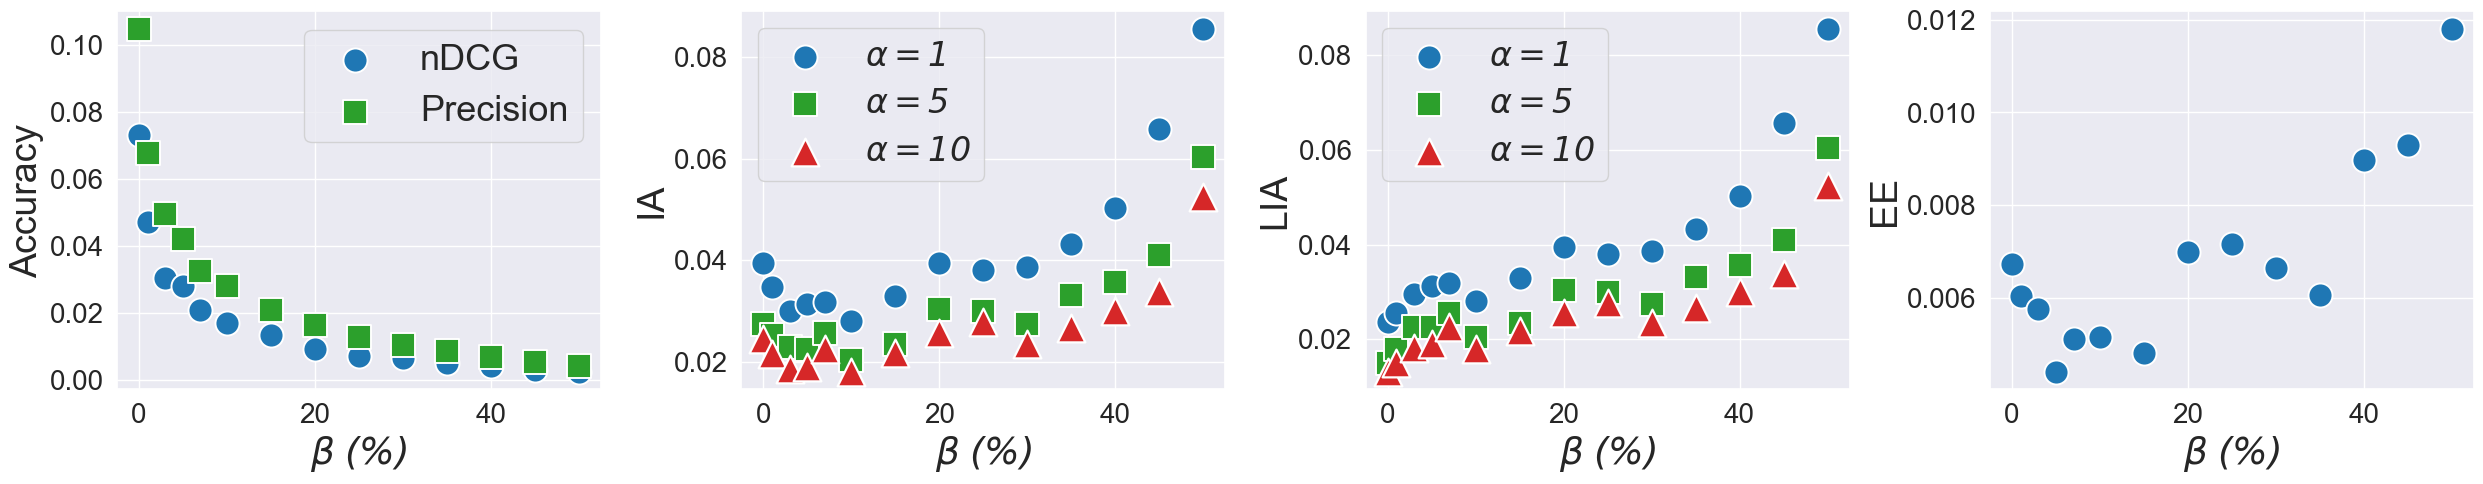

In [32]:
alg, input_type = 'biasedmf', 'rating'
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
ratios = [0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
ratios = [int(x * 100) for x in ratios]
test = pd.read_csv('datasets/'+dataset+'/test.txt',names=['userid','itemid','rate'],sep='\t')
train = pd.read_csv('datasets/'+dataset+'/train.txt',names=['userid','itemid','rate'],sep='\t')
items = list(train['itemid'].unique())
df_pop = popularity_computation(train)
head, tail = create_HT(train, 0.2)

fig = plt.figure(figsize=(25, 5))

ylbl, xlbl, ytick, xtick, legend = 27, 27, 20, 20, 26 

plt.subplot(1, 4, 1)
ndcg_df = pd.DataFrame({'x': ratios, 'y': ndcg})
precision_df = pd.DataFrame({'x': ratios, 'y': precision})
ax = sns.scatterplot(data=ndcg_df, x="x", y="y", color=colors[0], marker=markers[0], s=300, label='nDCG')
ax = sns.scatterplot(data=precision_df, x="x", y="y", color=colors[2], marker=markers[1], s=300, label='Precision')
ax.set(xlabel=None)  
ax.set_ylabel("Accuracy", fontsize=ylbl)
ax.set_xlabel(r"$\beta \;(\%)$", fontsize=xlbl)
ax.tick_params(axis='x', labelsize=xtick)
ax.tick_params(axis='y', labelsize=ytick)
ax.legend(fontsize=legend)

plt.subplot(1, 4, 2)
agg_div1_df = pd.DataFrame({'x': ratios, 'y': agg_div1})
agg_div5_df = pd.DataFrame({'x': ratios, 'y': agg_div5})
agg_div10_df = pd.DataFrame({'x': ratios, 'y': agg_div10})
ax = sns.scatterplot(data=agg_div1_df, x="x", y="y", color=colors[0], marker=markers[0], s=300, label=r'$\alpha=1$')
ax = sns.scatterplot(data=agg_div5_df, x="x", y="y", color=colors[2], marker=markers[1], s=300, label=r'$\alpha=5$')
ax = sns.scatterplot(data=agg_div10_df, x="x", y="y", color=colors[1], marker=markers[2], s=400, label=r'$\alpha=10$')
ax.set(xlabel=None)  
ax.set_ylabel("IA", fontsize=ylbl)
ax.set_xlabel(r"$\beta \;(\%)$", fontsize=xlbl)
ax.tick_params(axis='x', labelsize=xtick)
ax.tick_params(axis='y', labelsize=ytick)
ax.legend(fontsize=legend-2)

plt.subplot(1, 4, 3)
agg_div1_df = pd.DataFrame({'x': ratios, 'y': agg_div1_lt})
agg_div5_df = pd.DataFrame({'x': ratios, 'y': agg_div5_lt})
agg_div10_df = pd.DataFrame({'x': ratios, 'y': agg_div10_lt})
ax = sns.scatterplot(data=agg_div1_df, x="x", y="y", color=colors[0], marker=markers[0], s=300, label=r'$\alpha=1$')
ax = sns.scatterplot(data=agg_div5_df, x="x", y="y", color=colors[2], marker=markers[1], s=300, label=r'$\alpha=5$')
ax = sns.scatterplot(data=agg_div10_df, x="x", y="y", color=colors[1], marker=markers[2], s=400, label=r'$\alpha=10$')
ax.set(xlabel=None)  
ax.set_ylabel("LIA", fontsize=ylbl)
ax.set_xlabel(r"$\beta \;(\%)$", fontsize=xlbl)
ax.tick_params(axis='x', labelsize=xtick)
ax.tick_params(axis='y', labelsize=ytick)
ax.legend(fontsize=legend-2)

plt.subplot(1, 4, 4)
position_exposure_df = pd.DataFrame({'x': ratios, 'y': equality})
ax = sns.scatterplot(data=position_exposure_df, x="x", y="y", color=colors[0], marker=markers[0], s=300)
ax.set_ylabel("EE", fontsize=ylbl)
ax.set_xlabel(r"$\beta \;(\%)$", fontsize=xlbl)
ax.tick_params(axis='x', labelsize=xtick)
ax.tick_params(axis='y', labelsize=ytick)
fig.tight_layout()

# Percentile  

Text(0, 0.5, 'Popularity')

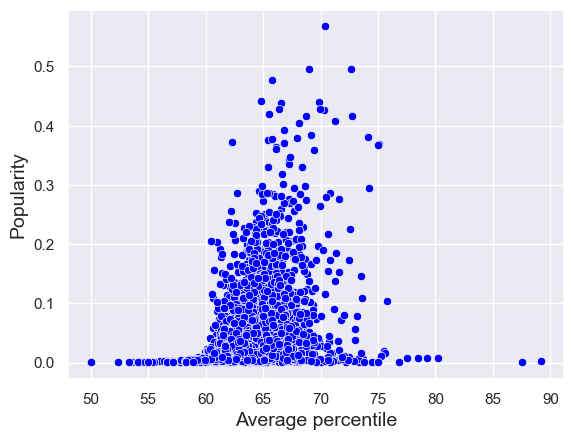

In [34]:
rating_percentile = pd.read_csv('datasets/'+dataset+'/percentile.txt',names=['userid','itemid','rate'], sep='\t')
df_pop = popularity_computation(rating_percentile)
df_avg_rating = rating_percentile[['itemid','rate']].groupby('itemid').mean()
df = pd.merge(df_pop, df_avg_rating, how='left', on=['itemid'])
ax = sns.scatterplot(data=df, x="rate", y="pop", color='blue')
ax.set_xlabel("Average percentile",fontsize=14)
ax.set_ylabel("Popularity",fontsize=14)